# Create a map of the internet
1. Download the 500 most important websites
2. Traceroute the path to these websites
3. Find additional information for all found servers
4. Create a network graph
5. Display the graph in gephi
6. Create some basic exploration plots

### Import

In [1]:
# Webscraping
import requests

# Parsing html
from bs4 import BeautifulSoup 

# Random samples
import random

# Data storage and analysis
import pandas as pd

# Regular expressions
import re

# Check IP-Addresses for more data
from ipwhois import IPWhois

# Displays progression bar
from tqdm import tqdm

# Ignore warnings for older packages
import warnings
warnings.filterwarnings('ignore')

# Plotting
import matplotlib.pyplot as plt
plt.style.use('ggplot')

### Scrape and store the most important websites

In [2]:
# List of Top 500 websites
url = 'https://moz.com/top500'

# Download and parse the website
html = requests.get(url).text
bs = BeautifulSoup(html, 'lxml')

# Scrape and store the URLs
# Iterate over every row of the table
websites = []
for elem in bs.findAll('td', {'class':'url'}):
    websites.append('www.'+elem.get_text().strip().lower())
        
# Store the websites to a txt-file
with open('Most_Important_Websites_List.txt', 'w') as file:
    for site in websites:
        file.write(site+'\n')
    
# Display a random sample
n = 5
print('{} random websites:\n{}'.format(n, random.sample(websites, n)))

5 random websites:
['www.ftc.gov', 'www.google.co.in', 'www.mozilla.com', 'www.feedburner.com', 'www.fortune.com']


### Trace the server hops to the websites with traceroute

A short bash-script in the console loops over the websites-file, traces the route and pipes the output to another file.

### Extract the important data from the traceroute-file

In [3]:
# Patterns to split the single traceroutes and extract the data
pattern1 = re.compile('traceroute to (.*?) ')
pattern2 = re.compile('(\d+\.\d+) ms')

# Loop over the traceroute-file line by line
data = []
with open('Traceroute_Most_Important_Websites.txt', 'r') as f:
    for line in f:
        try:
            # If a new traceroute starts, store the website
            if line.startswith('traceroute to '):
                destination = re.search(pattern1, line)[1]
            # Else extract the server, the times and store the data
            else:
                values = line.strip().split(' ')
                times = re.findall(pattern2, line)
                data.append([destination, int(values[0]), values[2], values[3][1:-1], float(times[0]), float(times[1]), float(times[2])])
        except:
            pass
        
# Store the extracted data in a DataFrame
df = pd.DataFrame(data, columns=['Destination', 'Hop', 'Server_Name', 'Server_IP', 'Time_1', 'Time_2', 'Time_3'])
df.tail()

,Destination,Hop,Server_Name,Server_IP,Time_1,Time_2,Time_3
4326,www.netscape.com,4,de-dtm01a-rd02-ae0-0.aorta.net,84.116.196.10,33.184,33.159,33.108
4327,www.netscape.com,5,de-fra01b-rc1-ae44-0.aorta.net,84.116.196.58,31.111,36.331,38.179
4328,www.netscape.com,6,de-fra01b-ri1-ae0-0.aorta.net,84.116.134.6,38.087,19.011,23.193
4329,www.netscape.com,7,dar1-frr.atdn.net,80.81.193.255,23.214,24.012,31.111
4330,www.netscape.com,8,edge1-frr-xe-0-0.net.aol.com,66.185.147.106,31.147,32.515,35.111


 ### Compute the edges of the graph for the internet-map

In [4]:
# Collect edges
edges = []

# Auxiliary variables 
website = None
current_source = None

# Loop over the DataFrame line by line
for destination, server_ip in df[['Destination', 'Server_IP']].values:
    # Save a hop from one IP to the next as edge in the graph
    
    # Check if a new traceroute begins
    if website != destination:
        edges.append([current_source, website])
        website = destination
        current_source = server_ip
    # Else the same traceroute continues
    else:
        new_source = server_ip
        edges.append([current_source, new_source])
        current_source = new_source
        
# Store the edges-data to file
edges_df = pd.DataFrame(edges[1:], columns=['source', 'target'])
edges_df.to_csv('Internet_Map_Edges.csv')

edges_df.head()

,source,target
0,192.168.0.1,84.116.197.145
1,84.116.197.145,84.116.196.10
2,84.116.196.10,84.116.196.58
3,84.116.196.58,84.116.132.178
4,84.116.132.178,103.4.96.182


### Download additional company-data and geographical-data for the IP-Adresses

###### Example of a response for more company-information:

<code>{'asn': '15169',
 'asn_cidr': '172.217.16.0/24',
 **'asn_country_code': 'US',**
 'asn_date': '2012-04-16',
 **'asn_description': 'GOOGLE - Google LLC, US',**
 'asn_registry': 'arin',
 'nets': [{'address': '1600 Amphitheatre Parkway',
   'cidr': '172.217.0.0/16',
   'city': 'Mountain View',
   'country': 'US',
   'created': '2012-04-16',
   'description': 'Google LLC',
   'emails': ['arin-contact@google.com', 'network-abuse@google.com'],
   'handle': 'NET-172-217-0-0-1',
   'name': 'GOOGLE',
   'postal_code': '94043',
   'range': '172.217.0.0 - 172.217.255.255',
   'state': 'CA',
   'updated': '2012-04-16'}],
 'nir': None,
 'query': '172.217.16.206',
 'raw': None,
 'raw_referral': None,
 'referral': None}</code>
 
 
 ##### Example of a response for more geographical-information:

<code>'Country: (Unknown Country?) (XX)\nCity: (Unknown City?)\n\nLatitude: \nLongitude: \nIP: 172.217.16.206\n'</code>

In [5]:
# Collects data
server_ip_data = []

# Pattern for the geographical data
geo_pattern = re.compile(': (.*?)\n')

# Loop over each unique Server-IP
for ip in tqdm(df['Server_IP'].unique()):
    # Try to get company-information for the IP-Address
    try:
        result = IPWhois(ip).lookup_whois()
        country_code = result['asn_country_code']
        company = result['asn_description']
    except:
        country_code = 'Unkown'
        company = 'Unkown'
        
    # Try to get geographical-information for the IP-Address
    try:
        response = requests.get('http://api.hostip.info/get_html.php?ip={}&position=true'.format(ip)).text.replace('?', '')
        country, city, lat, long, _ = re.findall(geo_pattern, response)
    except:
        country = 'Unkown'
        city = 'Unkown'
        lat = None
        long = None
    
    # Store the data
    server_ip_data.append([ip, country_code, company, country, city, lat, long])

# Store the data in a DataFrame    
node_df = pd.DataFrame(server_ip_data, columns=['id', 'Company_Country', 'Company', 'Country', 'City', 'Latitude', 'Longitude'])
node_df['Company_Short'] = node_df['Company'].apply(lambda x: x.split(' ', 1)[0] if type(x)==str else 'Unkown')
node_df.to_csv('Internet_Map_Nodes.csv', index=False)
node_df.tail()

100%|██████████| 1280/1280 [29:46<00:00,  1.02s/it]  


,id,Company_Country,Company,Country,City,Latitude,Longitude
1275,209.17.5.201,US,"ORACLE-ASNBLOCK-ASN - Oracle Corporation, US",UNITED STATES (US),(Unknown city),,
1276,156.151.0.157,US,"ORACLE-ASNBLOCK-ASN - Oracle Corporation, US",UNITED STATES (US),"Cupertino, CA",37.3144,-122.047
1277,156.151.0.141,US,"ORACLE-ASNBLOCK-ASN - Oracle Corporation, US",UNITED STATES (US),"Cupertino, CA",37.3144,-122.047
1278,80.81.193.255,DE,NA,GERMANY (DE),Frankfurt,50.1167,8.68333
1279,66.185.147.106,US,"AOL-ATDN - AOL Transit Data Network, US",UNITED STATES (US),"New York, NY",40.6698,-73.9438


### Creating the Internet-Map with the programm gephi

1. Open gephi and go to the 'Data Laboratory'
2. Import the nodes-file and afterwards the edges-file as spreadsheets
3. Choose the layout and start exploring the internet

![image](Internet_Map_Graph.png)

### Investigate the data of the internet servers

In [10]:
# Load the nodes DataFrame
node_df = pd.read_csv('Internet_Map_Nodes.csv')

def plotPercentageRanking(column, n=5):
    # Compute the percentage and plot the most important items
    title = '{}: Percentage of the servers on the internet'.format(column)
    (node_df[column].value_counts()/node_df.shape[0]).head(n).plot(kind='barh', figsize=(14,5), title=title)
    plt.gca().invert_yaxis()
    plt.xlabel('Percentage')
    plt.ylabel(column)
    plt.show()

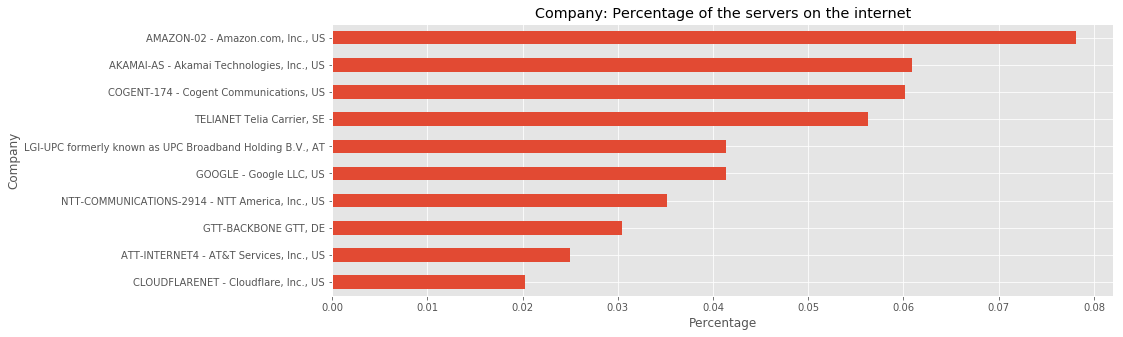

In [11]:
plotPercentageRanking('Company', n=10)

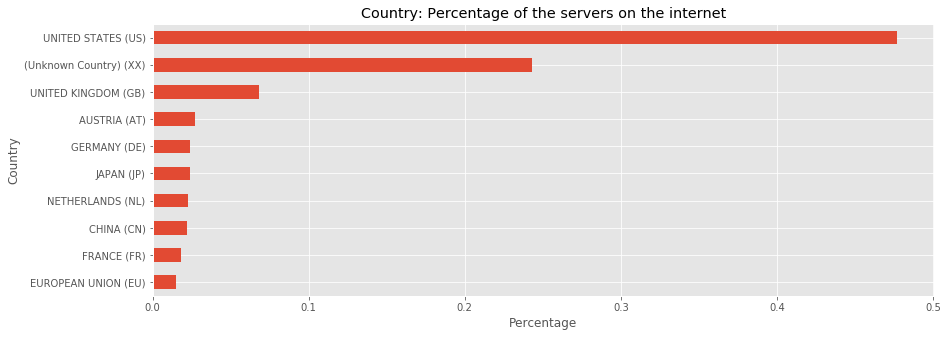

In [12]:
plotPercentageRanking('Country', n=10)

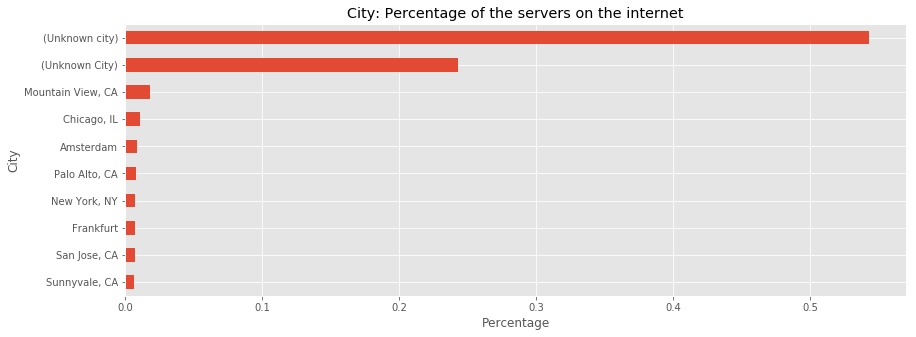

In [13]:
plotPercentageRanking('City', n=10)

![image](Internet_Map_Graph.png)